# Imports

In [164]:
%pip install emojis
%pip install pyarabic

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pyarabic in c:\users\z\anaconda3\lib\site-packages (0.6.15)



In [165]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import *

# Preprocessing

In [166]:
dframe = pd.read_csv('C:/Users/Z/Downloads/ar_suicide2.csv')
trainTweets = dframe.iloc[:, 0]
classes = dframe.iloc[:, 1]
classes = ['Depression' if cls == 1 else 'Normal' for cls in classes]

In [167]:
from nltk.corpus import stopwords
import emojis

def remove_stop_words(text): 
    stop_words = set(stopwords.words("arabic"))
    output = []
    for x in text:
        br = x.split() #returns list of words split by the default separator whitespace (" ")
        output.append(" ".join([word for word in br if word not in stop_words])) #any word not in stopwords is added to tweet
    return output

import re

def remove_emojis(text):
    emoji_pattern = re.compile("[" #creates re.Pattern object
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    words = []
    for word in text:
        words.append(emoji_pattern.sub(r'', word)) #substitutes any of the unicodes with ''
    return words


def remove_punctuation(text):
    words = []
    for word in text:
        words.append(re.sub(r'[^\w\s]','',word))
    return words


# in Arabic syllabels are represented by small signs above or below 
# each character, we will remove them 
# and see if they affect our prediction model
import pyarabic.araby as araby

def remove_diactrics(text): #also known as harakat
    words = []
    for word in text:
        words.append(araby.strip_diacritics(word))
    return words



# Normalization

In [168]:
from nltk.stem.isri import ISRIStemmer
stemmer = ISRIStemmer()

def stem(text):
    stemmed = []
    for word in text:
        stemmed.append(stemmer.stem(word))
    return stemmed

def stem_untokenized(text):
    return stemmer.stem(text)

In [169]:
def GetPaddedSequences(tokenizer, data, maxLength=50, truncating='post', padding='post'):
    #"pre" means start from the beginning,"post" means start from the ending
  sequences = tokenizer.texts_to_sequences(data)
  padded = pad_sequences( 
    sequences,
    truncating=truncating, #truncating will tell us how to handle sequences that are more than the max length.
    padding=padding, #padding will help us pad the sequences that are smaller than the matrix
    maxlen=maxLength
  )
    #pad_Sequences will help us make all the sequences of the same length, + so no information is lost in the CNN.
  return padded

In [170]:
trainTweets = remove_stop_words(trainTweets)
trainTweets = remove_emojis(trainTweets)
trainTweets = remove_punctuation(trainTweets)
trainTweets = remove_diactrics(trainTweets)
trainTweets = np.array(trainTweets)
trainLabels = classes
stemmed_train = stem(trainTweets)


In [171]:
testdf = pd.read_csv("C:/Users/Z/Downloads/datasetnlp.csv", encoding="latin-1")
testTweets = testdf.iloc[:, 0]
classes = testdf.iloc[:, 1]
classes = ['Depression' if cls == 1 else 'Normal' for cls in classes]

testTweets = remove_stop_words(testTweets)
testTweets = remove_emojis(testTweets)
testTweets = remove_punctuation(testTweets)
testTweets = remove_diactrics(testTweets)
testTweets = np.array(testTweets)
testLabels = classes
stemmed_test = stem(testTweets)


In [172]:
trainSize = 0.85
maxLength = 100
noOfWords = 2500
epochs = 2
batchSize = 32
trainSize = 0.85
embedSize = 300
overwrite = False


In [173]:
tokenizer = Tokenizer(num_words=noOfWords, oov_token='<UNK>') #

tokenizer.fit_on_texts(stemmed_train)
trainPaddedSequences = GetPaddedSequences(tokenizer, stemmed_train, maxLength=maxLength)


tokenizer.fit_on_texts(stemmed_test)
testPaddedSequences = GetPaddedSequences(tokenizer, stemmed_test, maxLength=maxLength)

print(trainPaddedSequences.shape)
print(testPaddedSequences.shape)

uniqueClasses = set(classes)
noOfClasses = len(uniqueClasses)
class2index = dict((c, i) for i, c in enumerate(uniqueClasses))
index2class = dict((v, k) for k, v in class2index.items())

names2ids = lambda labels: np.array([class2index.get(x) for x in trainLabels])
trainLabelsIDs = names2ids(trainLabels)
trainLabelsCat = to_categorical(trainLabelsIDs, num_classes=noOfClasses)

names2ids = lambda labels: np.array([class2index.get(x) for x in testLabels])
testLabelsIDs = names2ids(testLabels)
testLabelsCat = to_categorical(testLabelsIDs, num_classes=noOfClasses)

print(trainLabelsCat.shape)
print(testLabelsCat.shape)

(3087, 100)
(46999, 100)
(3087, 2)
(46999, 2)


In [197]:
def ModelCNN1(): 
  tf.keras.backend.clear_session()

  model = Sequential( # initialize instance of a sequential model
    [
      Embedding(noOfWords, 128, input_length=maxLength),
      Conv1D(32, 5, activation='relu'),
      MaxPooling1D(),
      Conv1D(64, 5, activation='relu'),
      MaxPooling1D(),
      Conv1D(128, 5, activation='relu'),
      MaxPooling1D(),
      Flatten(),
      Dense(32, activation='relu'),
      Dropout(0.5),
      Dense(64, activation='relu'),
      Dropout(0.5),
      Dense(2, activation='softmax'), 
    ]
  )
    
  model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics = [
    'accuracy',
    TruePositives(name="TP"),
    TrueNegatives(name="TN"),
    FalsePositives(name="FP"),
    FalseNegatives(name="FN"),
  ],
  )
  model.summary()

  history = model.fit(
    trainPaddedSequences, trainLabelsCat,
    validation_data=(testPaddedSequences, testLabelsCat),
    epochs=epochs,
    batch_size=batchSize,
    callbacks=[
      EarlyStopping(monitor='val_accuracy', patience=25), #patience is the number of epoches allowed for the monitored metric, every epoch, the metric is checked to  see if it has improved if not , it will stop early and take another specified action. 
      ModelCheckpoint("model.hdf5", monitor='val_loss'), #incase the validation metric does improve and there is less loss, the modelcheckpoint will save the weights of the model into the file, in this model.hdf5. this helps keep track of best weights and improvements.
    ] #these callbacks will help stop the training early if the model validation does not improve which will solve computational resources and prevent overfitting.
  )
 
  return model, history

In [199]:
model, history = ModelCNN1()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          320000    
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            20512     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 44, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 22, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 18, 128)           4

In [195]:
import tensorflow_docs as tfdocs
def ModelLSTM1():
  model = Sequential()
  model.add(Embedding(noOfWords, 128, input_length=maxLength)),
  model.add(Conv1D(32, 5, activation='relu')),
  model.add(MaxPooling1D()),
  model.add(LSTM(32))
  model.add(Dropout(0.4))
  model.add(Dense(2,activation='softmax'))
  
  metrics = [
    'accuracy',
    TruePositives(name="TP"),
    TrueNegatives(name="TN"),
    FalsePositives(name="FP"),
    FalseNegatives(name="FN"),
  ]

  model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=metrics,
  )
  model.summary()

  history = model.fit(
     trainPaddedSequences, trainLabelsCat,
    validation_data = (testPaddedSequences, testLabelsCat),
    epochs=2,
    batch_size=batchSize,
  )
    
  return model, history

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 128)          320000    
                                                                 
 conv1d_5 (Conv1D)           (None, 96, 32)            20512     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 48, 32)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                      

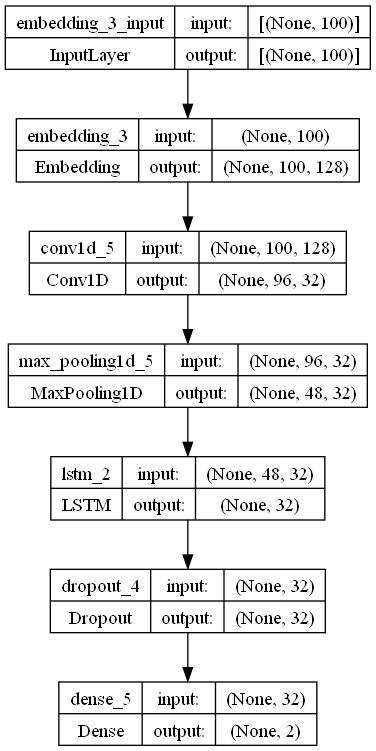

In [196]:
model, history = ModelLSTM1()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
